In [1]:
import numpy as np

import matplotlib.pyplot as plt
import igraph as ig
from pathlib import Path
import geopandas as gpd
from eptnr.datasets.dataset_loader import load_dataset
from eptnr.datasets.synthetic_datasets import SyntheticDatasets
from eptnr.rewards.egalitarian import EgalitarianTheilAndCostReward
from eptnr.constants.travel_metric import TravelMetric
from eptnr.plotting.data_exploration import plot_travel_time_histogram
from eptnr.analysis.full_problem_exploration import full_problem_exploration
import pandas as pd
from eptnr.algorithms.baselines.optimal_baseline import optimal_max_baseline
import seaborn as sns

# Dataset loading

In [2]:
graph = ig.read(Path('../eptnr_package/eptnr/datasets/amsterdam_10_2022/resulting_graph/Amsterdam_problem_graph_2022-11-05.gml'))

In [3]:
census = gpd.read_parquet(Path('../eptnr_package/eptnr/datasets/amsterdam_10_2022/ams_census_and_neighborhood_data_2021.parquet'),)
census["neighborhood"] = 'RC_' + census['BU_NAAM']
census['n_inh'] = census['a_inw']
census["res_centroids"] = census["res_centroid"]
census["geometry"] = census["res_centroid"]

all_w_nw_inh = census['a_w_all'] + census['a_nw_all'] + 0.0001

census["n_western"] = (census['a_inw'] * (census['a_w_all'] / all_w_nw_inh)).astype('int')
census["n_non_western"] = census['a_inw'] - census["n_western"]

census = census[["neighborhood", "n_inh", "n_western", "n_non_western", "geometry"]]

In [4]:
census

neighborhood  n_inh  n_western  n_non_western  \
0                  RC_Kop Zeedijk   1110        721            389   
1               RC_Oude Kerk e.o.    695        466            229   
2              RC_Burgwallen Oost   1645       1023            622   
3                     RC_Nes e.o.    365        276             89   
4              RC_BG-terrein e.o.    690        444            246   
..                            ...    ...        ...            ...   
443              RC_Gein Zuidwest   1665        201           1464   
444             RC_Gein Noordoost   3245        943           2302   
445              RC_Gein Zuidoost   3355        602           2753   
446              RC_Dorp Driemond   1480        662            818   
447  RC_Landelijk gebied Driemond    140         83             57   

                     geometry  
0    POINT (4.90009 52.37552)  
1    POINT (4.89678 52.37375)  
2    POINT (4.89875 52.37283)  
3    POINT (4.89423 52.37094)  
4    POINT (4.89588 52.36999)  
..                        ...  
443  POINT (4.98511 52.29471)  
444  POINT (4.99445 52.29913)  
445  POINT (4.99021 52.29315)  
446  POINT (5.01649 52.30562)  
447  POINT (5.01314 52.30975)  

[448 rows x 5 columns]

<AxesSubplot: xlabel='value', ylabel='Count'>

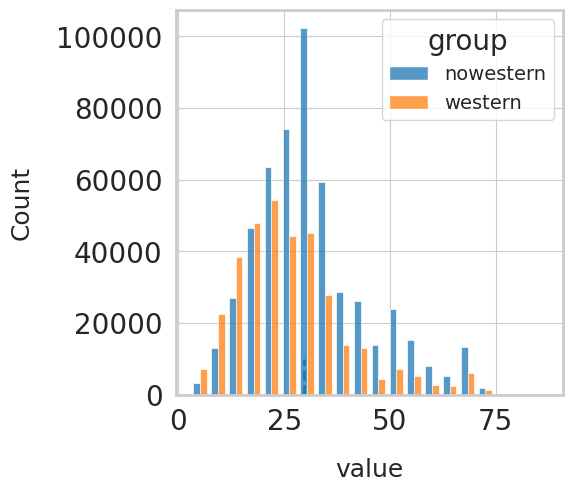

In [5]:
plot_travel_time_histogram(graph, census)

In [6]:
total_graph_cost = sum(graph.es.select(type_ne='walk')['cost'])
total_graph_cost

468865.7190800001

In [7]:
# What GVB needs to save (30%)
monetary_budget = total_graph_cost * 0.3
groups = None
metrics = [TravelMetric.TT]

# Deep MaxQ-Learning

In [8]:
from eptnr.algorithms.deep_rl.deep_q_learning.deep_max_q_learner import DeepMaxQLearner

reward = EgalitarianTheilAndCostReward(census_data=census, com_threshold=0,
                                       total_graph_cost=total_graph_cost, monetary_budget=monetary_budget,
                                       groups=groups, metrics=metrics, verbose=True)
edge_types = set(graph.es.select(type_ne='walk')['type'])
episodes = 128
batch_size = 64
replay_memory_size = 2048
target_network_update_step = 16
static_eps_steps = 64

In [9]:
edge_types

{'METRO'}

In [10]:
dmql = DeepMaxQLearner(
    base_graph=graph,
    reward=reward,
    edge_types=edge_types,
    episodes=episodes,
    batch_size=batch_size,
    replay_memory_size=replay_memory_size,
    target_network_update_step=target_network_update_step,
    static_eps_steps=static_eps_steps
)

In [11]:
max_rewards_over_episodes, epsilon_over_episodes = dmql.train(return_max_rewards_over_episodes=True,
                                                              return_epsilon_over_episodes=True, verbose=True)

  0%|          | 0/128 [00:00<?, ?it/s]INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/rewards/base_reward.py:Received graph with:
	n_edges=18054	n_vertices=488Created subgraph:
	n_edges=18053
	n_vertices=488
INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/rewards/base_reward.py:Resulting rewards:
	calculated_reward=0.10150233136462072
	scaled_reward=0.10150233136462072
INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/rewards/base_reward.py:Received graph with:
	n_edges=18054	n_vertices=488Created subgraph:
	n_edges=18052
	n_vertices=488
INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/rewards/base_reward.py:Resulting rewards:
	calculated_reward=0.11451755671660928
	scaled_reward=0.11451755671660928
INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/rewards/base_reward.py:Received graph with:
	n_edges=18054	n_vertices=488Created subgraph:
	n_edges=18051

KeyboardInterrupt: 